In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

In [2]:
TRAIN_ROAD = 'zhengqi_train.txt'
TEST_ROAD = 'zhengqi_test.txt'

In [3]:
#数据存list里
train = []
with open(TRAIN_ROAD, 'r') as f:
    f.readline()
    for line in f.readlines():
        train.append(line.split())

In [4]:
#同样存list
test = []
with open(TEST_ROAD, 'r') as f:
    f.readline()
    for line in f.readlines():
        test.append(line.split())
test = np.array(test).reshape(-1,38)

In [5]:
print((len(train),len(train[0])))

(2888, 39)


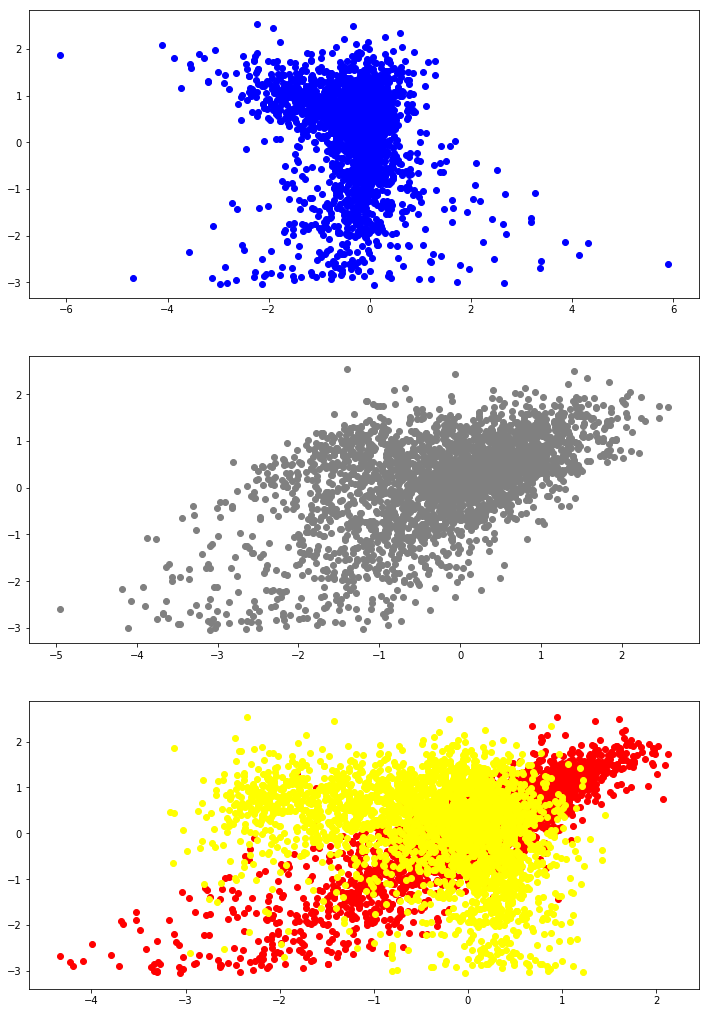

In [6]:
#又给转成了matrix，因为读的是str字符串，还得转成float32
train = np.array(train).reshape(-1,39).astype(np.float32)
target = train[:,-1].astype(np.float32)
#提取某两个特征，尝试看看有没有做特征工程的可能，毕竟没标签不敢乱做，要手动试一遍，其实可以循环的，只是我懒得滑滑轮
#主要看分布，还可以看看相关度，只是我看图上效果还行就没做这些...
v1 = train[:,0]
v2 = train[:,11]
v = v1 * v2
n = v1 + v2
plt.figure(figsize=(12,18))
plt.subplot(3,1,1)
plt.scatter(np.array(v).flatten(),np.array(target).flatten(),color='blue')
plt.subplot(3,1,2)
plt.scatter(np.array(n).flatten(), np.array(target).flatten(), color='gray')
plt.subplot(3,1,3)
plt.scatter(np.array(v1).flatten(),np.array(target).flatten(),color='red')
plt.scatter(np.array(v2).flatten(),np.array(target).flatten(),color='yellow')

plt.show()

In [7]:
print(len(target))
print(len(v))
print(len(train[:,-1]))

2888
2888
2888


In [8]:
#最后发现有几个特征太奇怪，就放到remove里等着去掉
good = [i for i in range(39)]
remove = [5,9,11,17,22,28,14,21,23,25,26,32,33,34,35]
for i in remove:
    good.remove(i)
good

[0,
 1,
 2,
 3,
 4,
 6,
 7,
 8,
 10,
 12,
 13,
 15,
 16,
 18,
 19,
 20,
 24,
 27,
 29,
 30,
 31,
 36,
 37,
 38]

In [9]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [10]:
real_train = list(train[:,good])

In [11]:
KF = KFold(n_splits=10)
model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.1,
       colsample_bytree=0.971, gamma=0.11, learning_rate=0.069, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=499,
       n_jobs=-1, nthread=50, objective='reg:linear', random_state=0,
       reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0)

In [12]:
#有点后悔，用pandas就可以直接删除没用的数据了，到这一步提取数据就要切片，就要占内存。幸亏数据不大.
import random

In [13]:
mse = []
random.shuffle(real_train)
print('train:', len(real_train),len(real_train[0]))
real_train = np.array(real_train).astype(np.float32)
t = [k for k in range(real_train.shape[1]-1)]
u = [len(t)]
for _train, _test in KF.split(real_train):
    train_data = real_train[_train][:,t]
    train_target = real_train[_train][:,u]
    test_data = real_train[_test][:,t]
    test_target = real_train[_test][:,u]
    print('cut...succeed...')
    model.fit(train_data, train_target)
    y_pred = model.predict(test_data).flatten()
    #均方差算误差
    xg_mse = mean_squared_error(y_true=test_target,y_pred=y_pred)
    mse.append(xg_mse)
    print('predict has finished...')
print('k折的所有损失函数: ',mse)

train: 2888 24
cut...succeed...
predict has finished...
cut...succeed...
predict has finished...
cut...succeed...
predict has finished...
cut...succeed...
predict has finished...
cut...succeed...
predict has finished...
cut...succeed...
predict has finished...
cut...succeed...
predict has finished...
cut...succeed...
predict has finished...
cut...succeed...
predict has finished...
cut...succeed...
predict has finished...
k折的所有损失函数:  [0.09822594, 0.12894806, 0.105076745, 0.10341799, 0.11679034, 0.13240048, 0.11408582, 0.13136382, 0.10858361, 0.09149652]


In [14]:
print('平均cost:', np.array(mse).mean())

平均cost: 0.11303892


In [15]:
print('test_shape:',len(test),len(test[0]))

test_shape: 1925 38


In [16]:
good.remove(38)
test_data = test[:, good]
test_data.shape, test.shape

((1925, 23), (1925, 38))

In [17]:
test_pred = model.predict(test_data)
test_pred.shape

(1925,)

In [18]:
test_pred.reshape(-1,1)

array([[ 0.32012147],
       [ 0.18268687],
       [ 0.07507846],
       ...,
       [-2.084258  ],
       [-2.6160028 ],
       [-2.3688767 ]], dtype=float32)

In [19]:
with open('predict.txt', 'w') as f:
    for i in test_pred:
        f.write(str(i)+'\n')